# ASTR596: Fundamentals of Data Science
## Week 1 In class exercise solutions - Part 3
#### Gautham Narayan <gsn@illinois.edu>

This notebook steps through the in class exercises during Week 1.
You are not required to do things this way, and indeed by the end of the semester, you'll probably have your own favorite ways to do things. That's totally OK.

In [1]:
# we use the numpy scipy and friends stack so much that it's worth just having things in the namespace
# you can do that with %pylab here
# The things that start with % are called `magics`
# There's a lot of them, and you can see the list here: 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x7fce6be092e0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Slide 62: Modeling multivariate data. 

Remmber that what we want is *P(H|D)* 

In part 2 we were using the data, and implictly trying to derive an empirical distribution function from the sample.
But what we want is not the empirical distribution function of the data, but knowledge of the underying probability distribution from which the data itself were drawn. 

The framework of Bayes' theorem gives us a way to do this using the posteriod *P(H|D)* 
But to do that, we need a *H*
Generally, this hypotheses will come from some physical information about the system being considered.
Often, hypotheses are simplifications/approximations, but they still give us some purchase to learn about our Universe.

This is summed up in a nice aphorism, attributed to George Box: 
### "All models are wrong but some are useful."

What we're doing here is seeing if we can describe data with a useful model.


---


We'll use the same dataset we used in part 2. 

You estimated the means in both x and y last Tuesday by eye, but now estimate the standard deviations by eye as well.

Use scipy.stats.multi_variate normal to construct a distribution object in python and overlay it with matplotlib (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)


Finally, see how well your eyeball estimate matches astroML.stats.fit_bivariate_normal

In [2]:
import h5py
import seaborn as sns
import pandas as pd

In [3]:
data = h5py.File('sdssj120650-20130310-total_mcmc.hdf5')
names = np.array(data['chain']['names'])
names = [x.decode('utf-8') for x in names]
pos = np.array(data['chain']['position'])
df = pd.DataFrame(pos[:,0:2], columns=[names[0],names[1]])

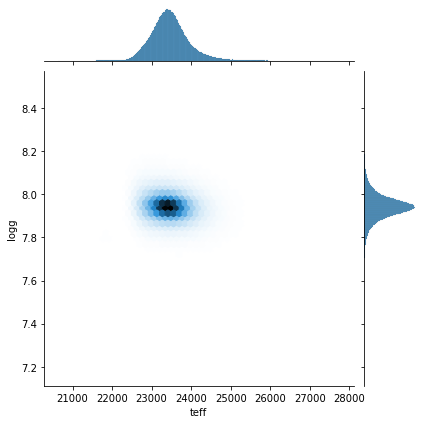

In [4]:
sns.jointplot(x='teff', y='logg', data=df, kind='hex')

In [5]:
# Based on our discussions in class, you estimated these means and standard deviations
# we'll use these to construct a multivariate (well bivariate here) normal distribution
# That distribution will be our model of the data.

mu_x = 23500.
mu_y = 7.9
sigma_x = 500.
sigma_y = 0.1

The multivariate normal looks very much like the 1D normal distribution, but with scalar X replaced by a vector in N-D imensions and the covariance replaced by a NxN matrix. The off-diagonal elements of this matrix represent the correlation between the dimensions - which for now we're going to assume is 0. Wrong but useful.

In [6]:
from scipy.stats import multivariate_normal

In [7]:
# first we should define a grid of points and spacing along each axis 
# on which we evaluate the multivariate normal PDF

# we can just read those of the plot above or from part 2
# we construct the grid with the numpy "meshgrid function"
# remember the array indexing notation is start:stop:stepsize
x, y = np.mgrid[21000:27000:300, 7.5:8.4:0.05]

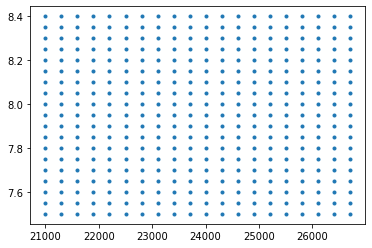

In [8]:
# we can visualize the grid easily
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, marker='.')

In [9]:
# this is grid of points on which we will evaluate the PDF, but we also need to store the actual p(x, y) values
# we can do that by constructing an empty array and adding an axis to store the z = p(x, y) values

pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

In [10]:
# now we need to construct our mean vector and covariance matrix
# remember that the variance is the square of the standard deviations you estimated

mu = [mu_x, mu_y]
covmat = [[sigma_x**2., 0.], [0., sigma_y**2]]

In [11]:
# we now have to initalize a multivariate normal object for our specific values of mu and sigma
rv = multivariate_normal(mu, covmat)

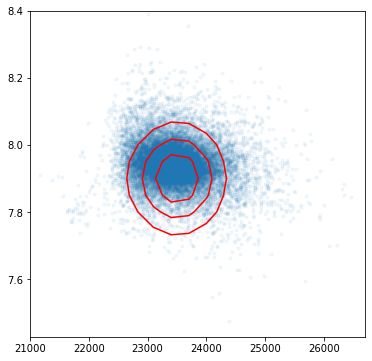

In [12]:
# ok, lets see if this model is a reasonable description of the data

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(df['teff'][::100], df['logg'][::100], marker='.', alpha=0.05)
ax.contour(x, y, rv.pdf(pos), levels=3, colors='r')

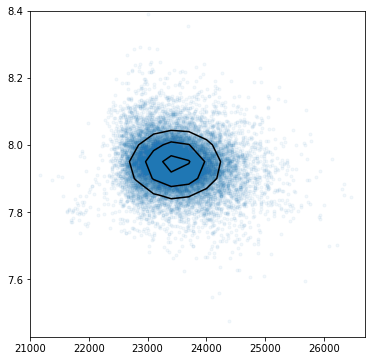

In [13]:
# we can do better by using the mean and standard deviation estimated from the data
# this is called the method of moments

mu_x = np.mean(df['teff'][::100])
mu_y = np.mean(df['logg'][::100])
sigma_x = np.std(df['teff'][::100])
sigma_y = np.std(df['logg'][::100])

mu = [mu_x, mu_y]
covmat = [[sigma_x**2., 0.], [0., sigma_y**2]]
rv = multivariate_normal(mu, covmat)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(df['teff'][::100], df['logg'][::100], marker='.', alpha=0.05)
ax.contour(x, y, rv.pdf(pos), levels=3, colors='k')

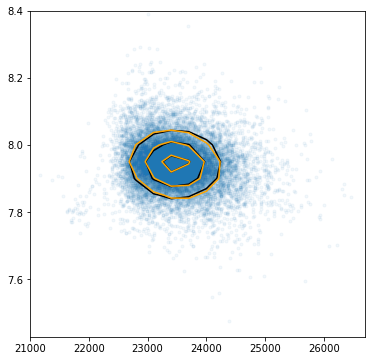

In [14]:
# that's better! We can refine even further if we use the covariance from the data

mu_x = np.mean(df['teff'][::100])
mu_y = np.mean(df['logg'][::100])
covmat = df[::100].cov()

rv2 = multivariate_normal(mu, covmat)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(df['teff'][::100], df['logg'][::100], marker='.', alpha=0.05)
ax.contour(x, y, rv.pdf(pos), levels=3, colors='k')
ax.contour(x, y, rv2.pdf(pos), levels=3, colors='orange')

In [15]:
# now we've used this to model bivariate data, but the procedure is general
# you can use it for any N-D dataset
# in the case of bivariate data, this is a nice convenience function that gives you 

from astroML.stats import fit_bivariate_normal

In [16]:
fitted_mu, fit_sig_x, fit_sig_y, theta = fit_bivariate_normal(df['teff'][::100], df['logg'][::100])

In [17]:
# compare what you get from the data:
print(mu, fitted_mu)

[23469.822265625, 7.941982746124268] [23469.834, 7.9419694]


In [18]:
print(sigma_x, fit_sig_x)
print(sigma_y, fit_sig_y)

483.25286865234375 483.25180060307747
0.06335979700088501 0.06285469773799178


The fitted mean, assuming a normal distribution and the sample mean are close, as are the fitted standard deviation and estimated standard deviation.

This is good but not unexpected because visibly the data looked reasonably consistent with a bivariate normal. This model was useful.

The converse is NOT true. 

If the moments of two distributions agree, that does not always mean that the distributions are in good agreement as we'll see in the next exercise.